# Movie Recommender Challenge

## Import Packages

In [1]:
import pandas as pd
import numpy as np

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy


from surprise.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from surprise.model_selection import GridSearchCV

# High performance hyperparameter tuning
#from tune_sklearn import TuneSearchCV
#import warnings
#warnings.filterwarnings("ignore")


/kaggle/input/edsa-recommender-system-predict/links.csv
/kaggle/input/edsa-recommender-system-predict/train.csv
/kaggle/input/edsa-recommender-system-predict/genome_scores.csv
/kaggle/input/edsa-recommender-system-predict/tags.csv
/kaggle/input/edsa-recommender-system-predict/imdb_data.csv
/kaggle/input/edsa-recommender-system-predict/test.csv
/kaggle/input/edsa-recommender-system-predict/sample_submission.csv
/kaggle/input/edsa-recommender-system-predict/genome_tags.csv
/kaggle/input/edsa-recommender-system-predict/movies.csv


## Import Data

In [2]:

ratings = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/train.csv')
test_df = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/test.csv')
df_movies = pd.read_csv('/kaggle/input/edsa-recommender-system-predict/movies.csv')

In [3]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId' ,'rating']], reader)

## Train head

In [4]:
print('Number of rows and columns in ratings data: {}'.format(ratings.shape))
ratings.head()

Number of rows and columns in ratings data: (10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


## Test head

In [5]:
print('Number of rows and columns in testset data: {}'.format(test_df.shape))
test_df.head()

Number of rows and columns in testset data: (5000019, 2)


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


# Check for missing data in any of the columns

## Train data

In [6]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

## Test data

In [7]:
test_df.isnull().sum()

userId     0
movieId    0
dtype: int64

## Visualize The Data

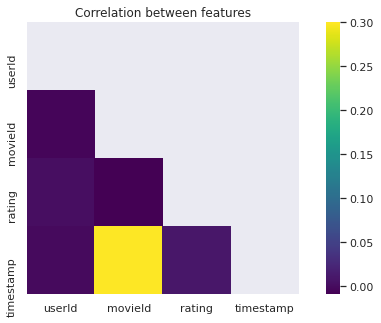

In [8]:
corr = ratings.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize = (10, 5))

ax = sns.heatmap(corr, 
                 mask = mask, 
                 vmax = 0.3, 
                 square = True,  
                 cmap = "viridis")

ax.set_title("Correlation between features");

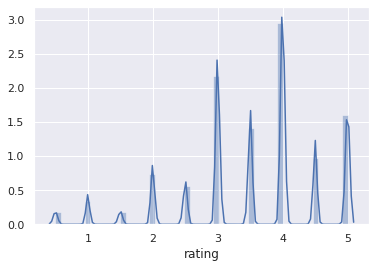

In [9]:
sns.distplot(ratings["rating"]);

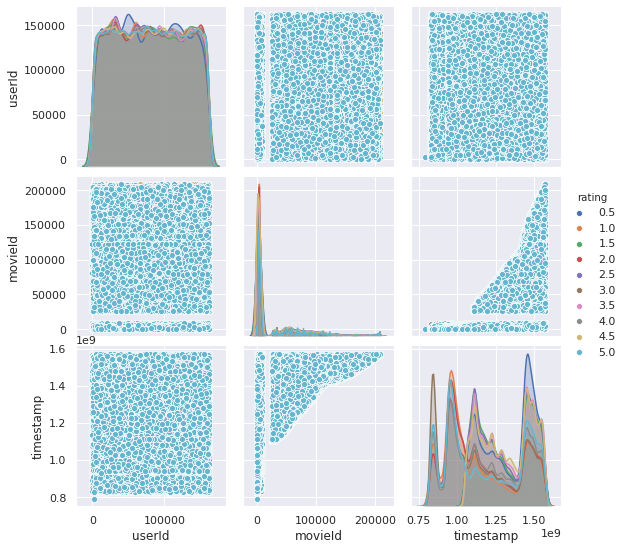

In [10]:
sns.pairplot(ratings, hue = "rating");

<BarContainer object of 19 artists>

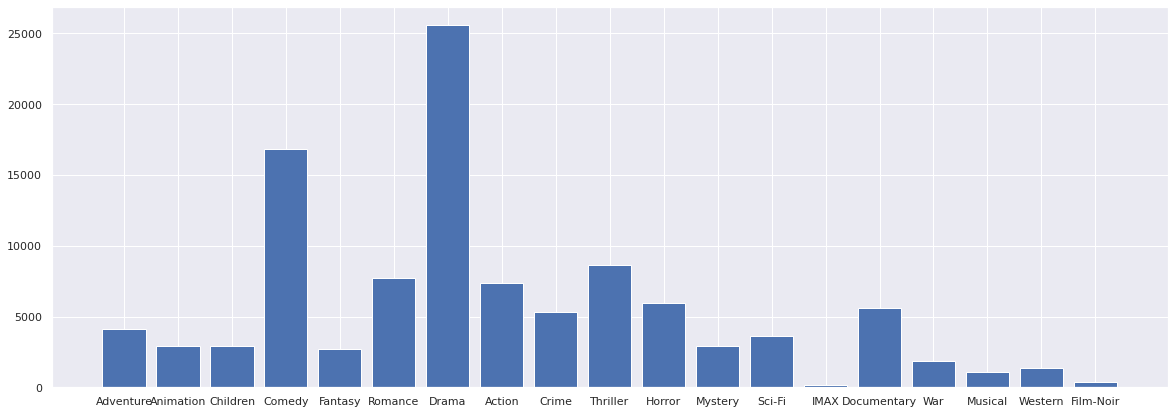

In [11]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='b')

## Building The Model

In [12]:
subset=ratings[:10000]

subset_matrix_items = subset.pivot_table(index = ['movieId'], columns = ['userId'], values = 'rating').reset_index(drop = True)
subset_matrix_items.shape

subset_matrix_items 

userId,4,12,59,61,67,72,84,155,166,175,...,162386,162403,162434,162442,162459,162473,162476,162478,162479,162488
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
trainset, testset = train_test_split(data, test_size=0.15)

In [14]:
algo = SVD()

algo.fit(trainset)

predictions = algo.test(testset) 
predictions

test = pd.DataFrame(predictions)

In [15]:
ratings_predictions=[algo.predict(row.userId, row.movieId) for _,row in test_df.iterrows()]
ratings_predictions

[Prediction(uid=1, iid=2011, r_ui=None, est=3.080337849944018, details={'was_impossible': False}),
 Prediction(uid=1, iid=4144, r_ui=None, est=4.232001945014047, details={'was_impossible': False}),
 Prediction(uid=1, iid=5767, r_ui=None, est=3.611645476525547, details={'was_impossible': False}),
 Prediction(uid=1, iid=6711, r_ui=None, est=4.121507368609917, details={'was_impossible': False}),
 Prediction(uid=1, iid=7318, r_ui=None, est=3.0440801234765513, details={'was_impossible': False}),
 Prediction(uid=1, iid=8405, r_ui=None, est=3.901436799017614, details={'was_impossible': False}),
 Prediction(uid=1, iid=8786, r_ui=None, est=3.980001601690627, details={'was_impossible': False}),
 Prediction(uid=2, iid=150, r_ui=None, est=3.5481450546540616, details={'was_impossible': False}),
 Prediction(uid=2, iid=356, r_ui=None, est=3.466810932966343, details={'was_impossible': False}),
 Prediction(uid=2, iid=497, r_ui=None, est=3.5250460799599073, details={'was_impossible': False}),
 Predictio

In [16]:
df_pred=pd.DataFrame(ratings_predictions)
df_pred

,uid,iid,r_ui,est,details
0,1,2011,None,3.080338,{'was_impossible': False}
1,1,4144,None,4.232002,{'was_impossible': False}
2,1,5767,None,3.611645,{'was_impossible': False}
3,1,6711,None,4.121507,{'was_impossible': False}
4,1,7318,None,3.044080,{'was_impossible': False}
...,...,...,...,...,...
5000014,162541,4079,None,3.238648,{'was_impossible': False}
5000015,162541,4467,None,3.925531,{'was_impossible': False}
5000016,162541,4980,None,2.853853,{'was_impossible': False}
5000017,162541,5689,None,2.838033,{'was_impossible': False}


In [17]:
df_pred=df_pred.rename(columns={'uid':'userId', 'iid':'movieId','est':'rating'})
df_pred.drop(['r_ui','details'],axis=1,inplace=True)

In [18]:
df_pred.head()

,userId,movieId,rating
0,1,2011,3.080338
1,1,4144,4.232002
2,1,5767,3.611645
3,1,6711,4.121507
4,1,7318,3.044080


In [19]:
reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(df_pred[['userId', 'movieId' ,'rating']], reader)

cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

{'test_rmse': array([0.3031506 , 0.30284234, 0.30270741]),
 'fit_time': (405.2954685688019, 408.9240231513977, 408.707172870636),
 'test_time': (31.661121606826782, 30.36264395713806, 31.1672625541687)}

In [20]:
param_grid = {'n_epochs': [5, 10,15], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6, 0.8]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=2)

gs.fit(data)

print(gs.best_score['rmse'])

print(gs.best_params['rmse'])

0.37573081482986603
{'n_epochs': 15, 'lr_all': 0.005, 'reg_all': 0.4}


In [21]:
df_pred.userId=df_pred['userId'].astype(int)
df_pred.movieId=df_pred['movieId'].astype(int)

In [22]:
df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)
df_pred['Id']=df_pred.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [23]:
predict=df_pred[['Id','rating']]

In [24]:
submission = pd.DataFrame({"Id":predict.Id, "rating":predict.rating})
submission.to_csv("SampleSub_First.csv", index=False)

In [25]:
submission.shape

(5000019, 2)

In [26]:
#algo = SVD(n_factors = 200 , lr_all = 0.005 , reg_all = 0.02 , n_epochs = 40 , init_std_dev = 0.05)
#cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)
#sim_cos = {'name':'cosine', 'user_based':False}   

#basic = knns.KNNBasic(sim_options=sim_cos)
#basic
#basic.fit(trainset)
#basic.sim
#sim_pearson = {'name':'pearson', 'user_based':False}
#knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
